# PedSilicoICH: Part 1. Phantoms

This notebook introduces the features and uses of the PedSilicoICH tool for generating anthropomorphic ground truth phantoms - currently based on the MIDA phantom and NIHPD MR brain atlases as a base - with models of intracranial hemorrhage, specifically intraparenchymal (IPH), epiural (EDH), and subural (SDH) hemorrages.liver metastases.

This notebook also introduces concepts of the `Phantoms` Class

These first few cells which download the data and load it are taken from: https://github.com/DIDSR/pediatricIQphantoms/blob/main/notebooks/02_pediatric_denoising_evaluation.ipynb

In [1]:
%pip install --upgrade pip -q
%pip install torchvision -q
%pip install seaborn -q
%pip install matplotlib -q
%pip install ipywidgets -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pydicom
from torchvision.datasets.utils import download_and_extract_archive

base_dir = Path('data')

if not base_dir.exists():
    url ='https://zenodo.org/records/11267694/files/pediatricIQphantoms.zip'
    download_and_extract_archive(url, download_root=base_dir)
base_dir = base_dir / 'pediatricIQphantoms'

meta = pd.read_csv(base_dir / 'metadata.csv')
meta = meta[meta['series'] == 'ground truth']
meta.file = meta.file.apply(lambda o: base_dir.absolute() / o)
meta

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat
39,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,12.3,/home/brandon.nelson/Dev/VITools/notebooks/dat...,0.0,2,ground truth,0
80,13.1 cm CTP404,13.1,0.083333,newborn,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,14.4,/home/brandon.nelson/Dev/VITools/notebooks/dat...,1.0,6,ground truth,0
121,15.0 cm CTP404,15.0,0.083333,newborn,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,34.0,/home/brandon.nelson/Dev/VITools/notebooks/dat...,2.0,10,ground truth,0
162,15.1 cm CTP404,15.1,0.083333,newborn,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,16.6,/home/brandon.nelson/Dev/VITools/notebooks/dat...,3.0,14,ground truth,0
203,18.5 cm CTP404,18.5,2.000000,infant,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,20.4,/home/brandon.nelson/Dev/VITools/notebooks/dat...,4.0,18,ground truth,0
244,21.6 cm CTP404,21.6,12.000000,child,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,23.8,/home/brandon.nelson/Dev/VITools/notebooks/dat...,5.0,22,ground truth,0
285,29.2 cm CTP404,29.2,21.000000,adolescent,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,32.1,/home/brandon.nelson/Dev/VITools/notebooks/dat...,6.0,26,ground truth,0
326,35.0 cm CTP404,35.0,39.000000,adult,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,38.5,/home/brandon.nelson/Dev/VITools/notebooks/dat...,7.0,30,ground truth,0
728,11.2 cm MITA-LCD,11.2,0.083333,newborn,MITA-LCD,Siemens Somatom Definition,NaN,ground truth,NaN,12.0,/home/brandon.nelson/Dev/VITools/notebooks/dat...,8.0,34,ground truth,0
1130,13.1 cm MITA-LCD,13.1,0.083333,newborn,MITA-LCD,Siemens Somatom Definition,NaN,ground truth,NaN,14.0,/home/brandon.nelson/Dev/VITools/notebooks/dat...,9.0,38,ground truth,0


While this dataset has CT simulations from another framework (MIRT), let's just use the ground truth images

## Select a starting phantom

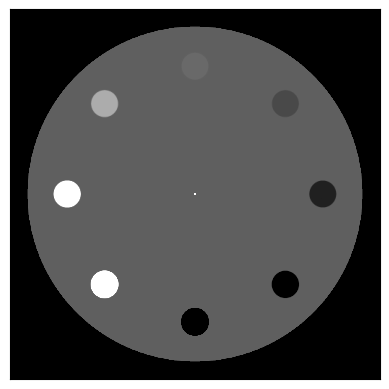

In [4]:
from VITools import read_dicom
from utils import ctshow

fname = meta.iloc[0]['file']

img = read_dicom(fname)
ctshow(img)

In [5]:
from VITools import Phantom

Phantom?

Init signature:
Phantom(
    img: numpy.ndarray,
    spacings: tuple = (1, 1, 1),
    patient_name='default',
    patientid=0,
    age=0,
) -> None
Docstring:     
Base phantom that can accept any img array and spacings which
    specify the size

:param img: 2D or 3D numpy array defining the phantom
:param spacings: tuple, voxel spacings [mm] (z, x, y), defining voxel
    sizes, defaults to 1 mm in each direction
:param patient_name: patient identifier to be saved in DICOM header
:param patientid: int, patient identifier to be saved in DICOM header
:param age: float, in years to be saved in DICOM header
File:           ~/Dev/VITools/src/VITools/phantoms.py
Type:           type
Subclasses:     

In [20]:
read_dicom??

Signature: read_dicom(dcm_fname: str) -> numpy.ndarray
Source:   
def read_dicom(dcm_fname: str) -> np.ndarray:
    '''
    Reads dicom file and returns numpy array

    :param dcm_fname: dicom filename to be read
    '''
    dcm = pydicom.read_file(dcm_fname)
    return dcm.pixel_array + int(dcm.RescaleIntercept)
File:      ~/Dev/VITools/src/VITools/image_acquisition.py
Type:      function

In [17]:
import pydicom

dcm = pydicom.read_file(fname)
spacings = tuple(map(float, (dcm.SliceThickness, *dcm.PixelSpacing)))
spacings

(0.240234375, 0.240234375, 0.240234375)

In [24]:
phantom_len_mm = 30  # in mm
slices = phantom_len_mm / spacings[0]
slices

124.8780487804878

In [27]:
img = dcm.pixel_array + int(dcm.RescaleIntercept)
img = np.repeat(img[None], int(slices), axis=0)
img.shape

(124, 512, 512)

In [28]:
phantom = Phantom(img, spacings)
phantom


        phantom class: Phantom
        age [yrs]: 0
        shape [voxels]: [124, 512, 512]
        size [mm]: [ 29.7890625 123.        123.       ]
        